# Prototipo GNN: Búsqueda de Camino Más Corto
## Datasets generation

### Librerías


In [1]:
# -*- coding: utf-8 -*-
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/GNN')

!pip uninstall -y tensorflow 
!pip install "tensorflow>=1.15,<2"
!pip install graph_nets "dm-sonnet<2" "tensorflow_probability<0.9"
!apt install --allow-change-held-packages libcudnn7=7.4.1.5-1+cuda10.0
#%tensorflow_version 1.x  # For Google Colab only.

Mounted at /content/drive
Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110.5 MB 1.3 kB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
     |████████████████████████████████| 3.8 MB 43.3 MB/s 
     |████████████████████████████████| 503 kB 61.6 MB/s 
     |████████████████████████████████| 50 kB 6.3 MB/s 
     |████████████████████████████████| 2.9 MB 30.0 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c5cc438dfeea38cb69f29f189596a486fb611691d69539e4c9803373dea5336e
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: numpy
    Found existing installation:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76 kB 2.8 MB/s 
     |████████████████████████████████| 665 kB 33.1 MB/s 
     |████████████████████████████████| 2.5 MB 44.0 MB/s 
  Created wheel for graph-nets: filename=graph_nets-1.1.0-py3-none-any.whl size=91857 sha256=46709d39cd1e629bb5e2b91c3db958f6667f12bdaba828c8f553ffb028b5f16b
  Stored in directory: /root/.cache/pip/wheels/44/3d/65/f2e8f0a8d0b28bea5f168fc717261a67303d2183a3e450c812
Successfully built graph-nets
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.5.0
    Uninstalling cloudpickle-1.5.0:
      Successfully uninstalled cloudpickle-1.5.0
  Attempting uninstall: tensorflow-probability
    Found existing installation: tensorflow-probability 0.16.0
    Uninstalling tensorflow-probability-0.16.0:
      Successfully uninstalled tensorflow-probability-0.16.0
ERROR: pip's dependency resolver does not c

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Debug
import pdb

# Miscelaneas
#%matplotlib widget
import sys
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
#import pandas as pd
#import collections
import pickle
#import time

# Graph nets
#from graph_nets import graphs
#from graph_nets import utils_np
#from graph_nets import utils_tf
#from graph_nets.demos import models
#from graph_nets.graphs import GraphsTuple
#import tensorflow as tf

# Py cgr
from py_cgr_lib.py_cgr_lib import Contact
from py_cgr_lib.py_cgr_lib import cgr_dijkstra
from py_cgr_lib.py_cgr_lib import cp_load_from_list

# Helper functions
from gnn_lib.gnn_lib import *


# Inicializacion del generador de numeros aleatorios
SEED = 1
np.random.seed(SEED)
rand = np.random.RandomState(seed=SEED)

# Desactivo la representacion cientifica de numpy
np.set_printoptions(suppress=True)

### Funciones especificas


In [3]:
def generate_sample_graphs(rand, path_FullContactPlan, timeWindowLength, numSamples):
  ''' Su objetivo es generar N grafos aleatorios y etiquetados con la ruta mas rapida, para la generacion usa de base un contactPlan.
  
  Parameters:
    rand <rand obj>: Maquina generadora de numeros aleatorios
    path_FullContactPlan <str>: Ruta al archivo del plan de contactos
    timeWindowLength <int>: Longitud en segundos de la ventana a considerar
    numSamples <int>: Cantidad de grafos a generar
    
  Returns:
    input_graphs <list(networkx.MultiDiGraph)>: lista de grafos con features para ser usados como input de la red neuronal
    target_graphs <list(networkx.MultiDiGraph)>: lista de grafos con features para ser usados como ground truth
  '''

  input_graphs  = []
  target_graphs = []
  
  # Cargamos el Full Contact Plan
  fullContactPlan = load_contactplan(path_FullContactPlan)
  
  for _ in range(numSamples):
    # si no existe ruta valida se eligen nuevos patametros aleatorios (t_inicial, node_A, node_B)
    flag_abort = 0
    target_graph = None
    while (target_graph==None) and (flag_abort<20):
      flag_abort+=1

      # Generamos parametros aleatorios
      t_inicial, t_final, node_A, node_B = generate_rand_param(rand, fullContactPlan, timeWindowLength, node_B=0)

      # Generamos un subContactPlan y su grafo asociado, partiendo de los parametros aleatorios obtenidos anteriormente
      input_graph, subContactPlan = generate_graph(fullContactPlan, t_inicial, t_final, node_A, node_B)

      # Agregamos la ruta calculada por CGR
      target_graph, _ = add_cgr_path(input_graph, subContactPlan)
    
    if target_graph==None:
      raise ValueError("Graph with invalid path")

    # Agrego los feactures a los grafos
    input_graph  = add_features_input(input_graph)
    target_graph = add_features_target(target_graph)

    # Append los grafos a las listas de salida
    input_graphs.append(input_graph)
    target_graphs.append(target_graph)

  return input_graphs, target_graphs


def plot_sample_graphs(graphs, numSamplesToPlot):
  ''' Su objetivo es graficar N grafos de una lista de grafos.
  
  Parameters:
    graphs <list(networkx.MultiDiGraph)>: Lista de grafos a graficar
    numSamplesToPlot <int>: Cantidad de grafos a graficar
    
  Returns:
    None: Plotea una figura con los N grafos.
  '''

  # Se utiliza la clase `GraphPlotter` para graficarlos (con la solución). 
  num = min(numSamplesToPlot, 16)
  w = 3
  h = int(np.ceil(num / w))
  fig = plt.figure(figsize=(w * 4, h * 4))
  fig.clf()

  for j, graph in enumerate(graphs[0:num]):
    ax = fig.add_subplot(h, w, j + 1)
    pos = nx.circular_layout(graph)
    plotter = GraphPlotter(ax, graph, pos)
    plotter.draw_graph_with_solution()

    # Add Labels
    for i in pos:
      ax.text(pos[i][0], pos[i][1], str(i), size=10, bbox=None, fontweight='bold',color='r', horizontalalignment="center", verticalalignment="center", zorder=110)


def get_stats_from_graph(graph, printEnable):
  ''' Su objetivo es obtener datos estadisticos de un grafo en especifico.
  
  Parameters:
    graph <networkx.MultiDiGraph>: Grafo a analizar
    printEnable <bool>: True: para imprimir en consola los resultados obtenidos en texto plano.
    
  Returns:
    numberOfNodes <int>: Numero de nodos presentes en el grafo
    numberOfEdges <int>: Numero de edges presentes en el grafo
    t_inicial <float>: Tiempo inicial considerado
    source_node <int>: Nodo de origen considerado
    destination_node <int>: Nodo de destino considerado
    numberOfHops <int>: Numero de saltos en la ruta calculada por CGR
  '''

  # Busco los nodos de origine y destino
  for i in graph.nodes.data():
    if i[1]['frm']:
      node_A = i[0]
    if i[1]['to']:
      node_B = i[0]
    
  # Obtengo parametros del grafo
  numberOfNodes    = graph.number_of_nodes()
  numberOfEdges    = graph.number_of_edges()
  t_inicial        = graph.graph['t_inicial']
  source_node      = node_A
  destination_node = node_B
  
  # Si el grafo tiene etiquedata la ruta correcta, obtengo el numero de saltos de la misma
  if 'path_nodes' in graph.graph:
    numberOfHops = len(graph.graph['path_edges'])
  else:
    numberOfHops = None

  # Imprimo en consola los valores calculados
  if printEnable:
    print("Estadisticas:")
    print("\tNumero de Nodos: " + str(numberOfNodes))
    print("\tNumero de Edges: " + str(numberOfEdges))
    print("\tT inicial: " + str(t_inicial))
    print("\tSource Node: " + str(source_node))
    print("\tDestination Node: " + str(destination_node))
    print("\tNumero de Hops: " + str(numberOfHops))
    
  return numberOfNodes, numberOfEdges, t_inicial, source_node, destination_node, numberOfHops


def get_stats_from_graphs(graphs, lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops):
  ''' Su objetivo es obtener datos estadisticos de una lista de grafos y representarla de la forma mas representativa.
  
  Parameters:
    graphs <list(networkx.MultiDiGraph)>: Lista de grafos, Dataset a analizar


  Returns:
    
  '''

  # Obtengo valores estadisticos de cada grafo de forma individual y almaceno los resultados
  for graph in graphs:
    numberOfNodes, numberOfEdges, t_inicial, source_node, destination_node, numberOfHops = get_stats_from_graph(graph, False)
    lst_numberOfNodes.append(numberOfNodes)
    lst_numberOfEdges.append(numberOfEdges)
    lst_t_inicial.append(t_inicial)
    lst_source_node.append(source_node)
    lst_destination_node.append(destination_node)
    lst_numberOfHops.append(numberOfHops)
  
  return lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops


def plot_hist_from_stats(lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops, title):
  ''' 
  
  Parameters:


  Returns:
    
  '''

  # Figura
  fig = plt.figure(figsize=(10, 5))
  fig.clf()

  # Plot: Histograma del numero de nodos presentes en los grafos
  ax = fig.add_subplot(2, 3, 1)
  ax.hist(lst_numberOfNodes, bins=range(min(lst_numberOfNodes)-1, max(lst_numberOfNodes)+3), align='left', rwidth=0.5)
  ax.set_title("Numero de nodos")
  ax.set_xlabel("numberOfNodes")
  ax.set_ylabel("# de casos")

  # Plot: Histograma del numero de edges presentes en los grafos
  ax = fig.add_subplot(2, 3, 2)
  ax.hist(lst_numberOfEdges, bins=range(min(lst_numberOfEdges)-1,max(lst_numberOfEdges)+3), align='left', rwidth=0.5)
  ax.set_title("Numero de edges")
  ax.set_xlabel("numberOfEdges")
  ax.set_ylabel("# de casos")

  # Plot: Histograma del tiempo inicial de los grafos
  ax = fig.add_subplot(2, 3, 3)
  ax.hist(lst_t_inicial, bins=20)
  ax.set_title("T inicial")
  ax.set_xlabel("t_inicial")
  ax.set_ylabel("# de casos")

  # Plot: Histograma de los nodos seleccionados como "nodo origen" en los grafos
  ax = fig.add_subplot(2, 3, 4)
  ax.hist(lst_source_node, bins=range(max(lst_numberOfNodes)+1), align='left', rwidth=0.5)
  ax.set_title("Source nodes")
  ax.set_xlabel("id source_node")
  ax.set_ylabel("# de casos")

  # Plot: Histograma de los nodos seleccionados como "nodo destino" en los grafos
  ax = fig.add_subplot(2, 3, 5)
  ax.hist(lst_destination_node, bins=range(max(lst_numberOfNodes)+1), align='left', rwidth=0.5)
  ax.set_title("Destination nodes")
  ax.set_xlabel("id destination_node")
  ax.set_ylabel("# de casos")

  # Plot: Histograma de la cantidad de saltos presentes en la ruta calculada por cgr para cada grafo
  ax = fig.add_subplot(2, 3, 6)
  if not None in lst_numberOfHops:
    ax.hist(lst_numberOfHops, bins=range(1, max(lst_numberOfHops)+3), align='left', rwidth=0.5)
  ax.set_title("Numero de Hops")
  ax.set_xlabel("numberOfHops")
  ax.set_ylabel("# de casos")

  # Imprimo el titulo de la figura
  plt.suptitle(title, fontsize=16, y=1.03)
  plt.tight_layout()


def balance_dataset(input_graphs, target_graphs):
  ''' Su objetivo es balancear el dataset en funcion del numero de saltos presentes en la ruta calculada por CGR.
  
  Parameters:
    input_graphs <list(networkx.MultiDiGraph)>: Lista de grafos de entrada
    target_graphs <list(networkx.MultiDiGraph)>: Lista de grafos etiquetados
    
  Returns:
    input_graphs <list(networkx.MultiDiGraph)>: Lista de grafos de entrada, balanceada
    target_graphs <list(networkx.MultiDiGraph)>: Lista de grafos etiquetados, balanceada
  '''

  # Obtendo la cantidad de grafos que cuentan con el mismo numero de saltos
  lst_numberOfHops = []
  for graph in target_graphs:
    lst_numberOfHops.append(len(graph.graph['path_edges']))
  x_values, y_values = np.unique(lst_numberOfHops, return_counts=True)

  # Obtengo la cantidad de grafos vs el numero de hops - objetivo
  y_objetive = []
  aux = y_values[-1]
  for _ in range(len(y_values)):
    y_objetive.append(aux)
    aux *= 2
  y_objetive.reverse()

  # Obtendo la cantidad de grafos que se deben eliminar en cada categoria
  y_diff = y_values - y_objetive
  numOfsamples_to_delet = dict(zip(x_values, y_diff))

  # Obtendo la lista de index a eliminar del dataset
  index = range(len(target_graphs))
  rand.shuffle(index)
  index_to_delet = []
  for i in index:
    numOfHops = len(target_graphs[i].graph['path_edges'])
    if numOfsamples_to_delet[numOfHops] > 0:
      numOfsamples_to_delet[numOfHops] -= 1
      index_to_delet.append(i)

  # Elimino los elementos del dataset
  index_to_delet.sort()
  for i in reversed(index_to_delet):
    input_graphs.pop(i)
    target_graphs.pop(i)
    
  return input_graphs, target_graphs


### Creacion de los datasets

Training Dataset Generation, In process...
Len after balance: 2048
File 0 Finished. Len: 2048
Len after balance: 2048
File 1 Finished. Len: 2048
Len after balance: 2048
File 2 Finished. Len: 2048
Len after balance: 2048
File 3 Finished. Len: 2048
Len after balance: 2048
File 4 Finished. Len: 2048
Training Dataset Generation, Finished
Testing Dataset Generation, In process...
Len after balance: 1024
File 0 Finished. Len: 1024
Len after balance: 1024
File 1 Finished. Len: 1024
Len after balance: 1024
File 2 Finished. Len: 1024
Len after balance: 1024
File 3 Finished. Len: 1024
Len after balance: 1024
File 4 Finished. Len: 1024
Testing Dataset Generation, Finished


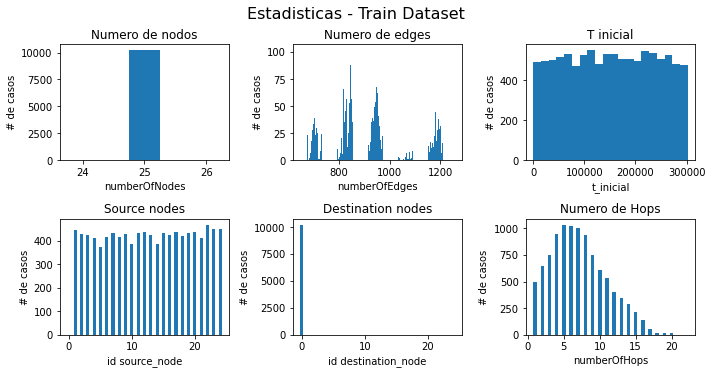

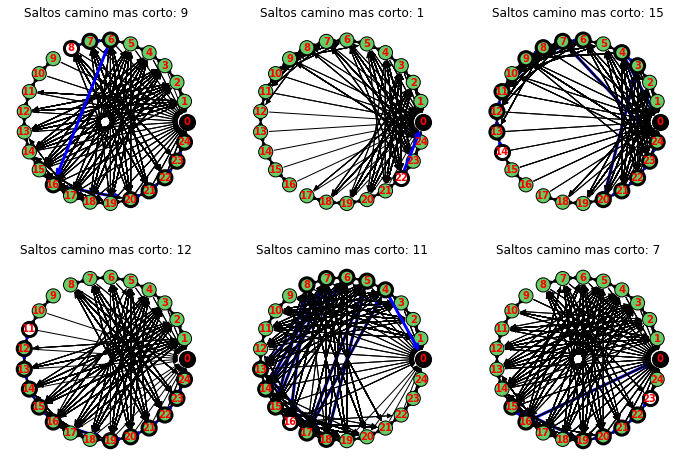

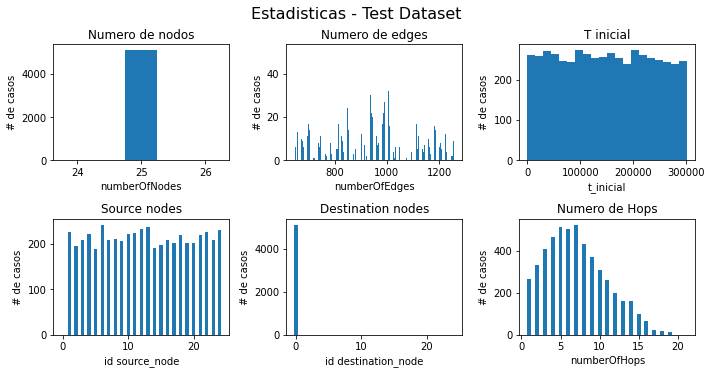

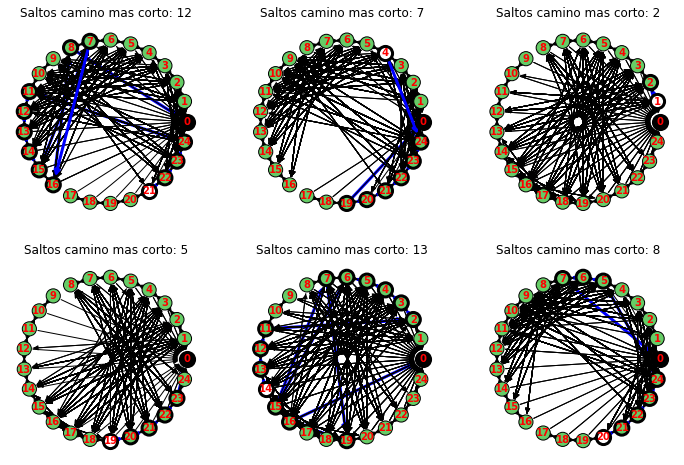

In [4]:
# Path a los archivos que definen los Contact Plan a utilizar
Path_FullContactPlan_train = "scenarios/GNN_Escenario_4_Train.txt"
Path_FullContactPlan_test  = "scenarios/GNN_Escenario_4_Test.txt"
datasetName = "Dataset_Escenario4"

# Longitud temporal de los Sub Contact Plan a utilizar [seg]
TimeWindowLength = 43200

# Numero de muestras a generar para cada dataset
BatchSize_train     = 32
TotalNumBatch_train = 320 # 10240 samples
NumBatchFile_train  = 64
NumFiles_train      = int(TotalNumBatch_train/NumBatchFile_train)
NumSamplesFile_train= NumBatchFile_train * BatchSize_train


BatchSize_test      = 128
TotalNumBatch_test  = 40  # 5120 samples
NumBatchFile_test   = 8
NumFiles_test       = int(TotalNumBatch_test/NumBatchFile_test)
NumSamplesFile_test = NumBatchFile_test * BatchSize_test



# ------------------------------------------ Training DataSet ------------------------------------------
lst_numberOfNodes    = []
lst_numberOfEdges    = []
lst_t_inicial        = []
lst_source_node      = []
lst_destination_node = []
lst_numberOfHops     = []

print("Training Dataset Generation, In process...")
for i in range(NumFiles_train):
    input_graphs_train_i  = []
    target_graphs_train_i = []

    while len(input_graphs_train_i) < NumSamplesFile_train:
        # Genero el dataset de training
        aux_input_graphs_train, aux_target_graphs_train = generate_sample_graphs(rand, Path_FullContactPlan_train, TimeWindowLength, NumSamplesFile_train)

        # Balanceo el dataset
        #aux_input_graphs_train, aux_target_graphs_train = balance_dataset(aux_input_graphs_train, aux_target_graphs_train)

        # Append los resultados
        input_graphs_train_i  += aux_input_graphs_train
        target_graphs_train_i += aux_target_graphs_train

        print("Len after balance: " + str(len(input_graphs_train_i)))

    # Ajusto la cantidad de grafos generados
    input_graphs_train_i = input_graphs_train_i[0:NumSamplesFile_train]
    target_graphs_train_i = target_graphs_train_i[0:NumSamplesFile_train]
    print("File " + str(i) + " Finished. Len: " + str(len(input_graphs_train_i)))

    # Calculo valores estadisticos y los almaceno
    lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops = \
        get_stats_from_graphs(target_graphs_train_i, lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops)

    # Guardo el dataset i
    with open('Datasets/' + datasetName + '_Train_InputGraphs_' + str(i) + '.pickle', 'wb') as file:
        pickle.dump(input_graphs_train_i, file, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Datasets/' + datasetName + '_Train_TargetGraphs_' + str(i) + '.pickle', 'wb') as file:
        pickle.dump(target_graphs_train_i, file, protocol=pickle.HIGHEST_PROTOCOL)

print("Training Dataset Generation, Finished")
# Visualizo los histogramas
plot_hist_from_stats(lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops, 'Estadisticas - Train Dataset')

# Visualizo los ultimos grafos generados
#plot_sample_graphs(input_graphs_train_i, 6)
plot_sample_graphs(target_graphs_train_i, 6)

# Libero memoria
del(input_graphs_train_i)
del(target_graphs_train_i)



# ------------------------------------------ Testing DataSet ------------------------------------------
lst_numberOfNodes    = []
lst_numberOfEdges    = []
lst_t_inicial        = []
lst_source_node      = []
lst_destination_node = []
lst_numberOfHops     = []

print("Testing Dataset Generation, In process...")
for i in range(NumFiles_test):
    input_graphs_test_i = []
    target_graphs_test_i = []

    while len(input_graphs_test_i) < NumSamplesFile_test:
        
        # Genero el dataset de testing
        aux_input_graphs_test, aux_target_graphs_test = generate_sample_graphs(rand, Path_FullContactPlan_train, TimeWindowLength, NumSamplesFile_test)

        # Balanceo el dataset
        #aux_input_graphs_test, aux_target_graphs_test = balance_dataset(aux_input_graphs_test, aux_target_graphs_test)

        # Append los resultados
        input_graphs_test_i  += aux_input_graphs_test
        target_graphs_test_i += aux_target_graphs_test

        print("Len after balance: " + str(len(input_graphs_test_i)))
    
    # Ajusto la cantidad de grafos generados
    input_graphs_test_i  = input_graphs_test_i[0:NumSamplesFile_test]
    target_graphs_test_i = target_graphs_test_i[0:NumSamplesFile_test]
    print("File " + str(i) + " Finished. Len: " + str(len(input_graphs_test_i)))

    # Calculo valores estadisticos y los almaceno
    lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops = \
        get_stats_from_graphs(target_graphs_test_i, lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops)

    # Guardo el dataset
    with open('Datasets/' + datasetName + '_Test_InputGraphs_' + str(i) + '.pickle', 'wb') as file:
        pickle.dump(input_graphs_test_i, file, protocol=pickle.HIGHEST_PROTOCOL)
    with open('Datasets/' + datasetName + '_Test_TargetGraphs_' + str(i) + '.pickle', 'wb') as file:
        pickle.dump(target_graphs_test_i, file, protocol=pickle.HIGHEST_PROTOCOL)

print("Testing Dataset Generation, Finished")
# Visualizo los histogramas
plot_hist_from_stats(lst_numberOfNodes, lst_numberOfEdges, lst_t_inicial, lst_source_node, lst_destination_node, lst_numberOfHops, 'Estadisticas - Test Dataset')

# Visualizo los ultimos grafos generados
#plot_sample_graphs(input_graphs_test_i, 6)
plot_sample_graphs(target_graphs_test_i, 6)

# Libero memoria
del(input_graphs_test_i)
del(target_graphs_test_i)

In [ ]:
# TODO List:
#  - Almacenar y cargar los datasets a memoria solo por batch, no todo el dataset.
#  - Graficar edges por separado

# Para mejorar:
#  - Normalizar tiempos entre 0 y 1
#  - toquetear parametros de entrenamiento
#  - agregar algun feature
#  - toquetear modelo 